In [1]:
# set Keras backend to Tensorflow
import os
import tensorflow as tf

os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [2]:
# import
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import pickle
import numpy as np

In [3]:
# make saving directory
saveDir = "./cifar10/combTest100/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [4]:
# get Cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x train shape:', x_train.shape)
print(x_train.shape[0], 'training images')
print(x_test.shape[0], 'test images')

x train shape: (50000, 32, 32, 3)
50000 training images
10000 test images


In [5]:
from keras.utils import np_utils
# prerequisite
num_classes = 10
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [6]:
initNum = 10000
x_train1 = x_train[:initNum]
y_train1 = y_train[:initNum]
remainXTrain = x_train[initNum:]
remainYTrain = y_train[initNum:]

In [7]:
print("initial training X: {0}\n\
initial training Y: {1}\n\
remaining training X: {2}\n\
remaining training Y: {3}\n\
test X: {4}\n\
test Y: {5}".format(
    x_train1.shape,y_train1.shape,remainXTrain.shape,remainYTrain.shape,x_test.shape,y_test.shape))

initial training X: (10000, 32, 32, 3)
initial training Y: (10000, 10)
remaining training X: (40000, 32, 32, 3)
remaining training Y: (40000, 10)
test X: (10000, 32, 32, 3)
test Y: (10000, 10)


In [8]:
labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [9]:
from tensorflow.keras.optimizers import Adam
# optimization and compile
def compileModel(model, lr=0.001, decay=1e-6):
    opt = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [10]:
# define layers
def getModel(loadModel=False, modelFilePath="", lr=0.001, decay=1e-6):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model = compileModel(model)
    
    # load model weights if specified
    if loadModel == True:
        model.load_weights(modelFilePath)
    
    return model

In [11]:
# get the newest model file
def getNewestModel(dirname=saveDir):
    import os
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return getModel()
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        return getModel(True, newestModel[0])

In [12]:
# get the CNN model
model = getModel()

In [13]:
# train the model
def trainModel(model, xTrain, yTrain, xTest, yTest, batch_size=50, epochs=100, patience=1):
    es_cb = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
    chkpt = os.path.join(saveDir, 'Cifar10_.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5')
    cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    # train
    model.fit(xTrain, yTrain,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(xTest, yTest),
              callbacks=[es_cb, cp_cb],
              shuffle=True)
    return model

In [14]:
# run training on the initial dataset

model = trainModel(model, x_train1, y_train1, x_test, y_test, patience=2)


Epoch 1: val_loss improved from inf to 1.56877, saving model to ./cifar10/combTest100\Cifar10_.01-1.91-1.57.hdf5

Epoch 2: val_loss improved from 1.56877 to 1.31746, saving model to ./cifar10/combTest100\Cifar10_.02-1.50-1.32.hdf5

Epoch 3: val_loss improved from 1.31746 to 1.26909, saving model to ./cifar10/combTest100\Cifar10_.03-1.31-1.27.hdf5

Epoch 4: val_loss improved from 1.26909 to 1.14037, saving model to ./cifar10/combTest100\Cifar10_.04-1.19-1.14.hdf5

Epoch 5: val_loss improved from 1.14037 to 1.11596, saving model to ./cifar10/combTest100\Cifar10_.05-1.07-1.12.hdf5

Epoch 6: val_loss improved from 1.11596 to 1.06153, saving model to ./cifar10/combTest100\Cifar10_.06-0.97-1.06.hdf5

Epoch 7: val_loss did not improve from 1.06153

Epoch 8: val_loss did not improve from 1.06153
Epoch 8: early stopping


In [15]:
# use the pre-trained model, with 65% accuracy on test data

model.load_weights("./cifar10/combTest100/Cifar10_.06-0.97-1.06.hdf5")

In [16]:
# define evaluation method
def evaluate(model, xTest, yTest, display=False):
    # only shows loss and accuracy
    if display == False:
        ev = model.evaluate(xTest, yTest, verbose=0)
        return ev
    # shows confusion matrix, classification report and accuracy score
    else:
        import pandas as pd
        import seaborn as sn
        import matplotlib.pyplot as plt
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import classification_report, accuracy_score

        def toNum(y):
            yNum = []
            for x in y:
                yNum.append(x.argmax())
            return np.array(yNum)

        # visualize confusion matrix on heat map
        def print_cmx(y_true, y_pred):
            labels = sorted(list(set(y_true)))
            cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

            df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

            plt.figure(figsize = (10,7))
            sn.heatmap(df_cmx, annot=True)
            plt.show()

        # reshape testing target to fit to scikit-learn metric form
        y_testPred = model.predict(xTest)
        y_testP = toNum(y_testPred)
        y_true = toNum(yTest)

        # get confusion matrix, classification report and accuracy score
        print_cmx(y_true, y_testP)
        print(classification_report(y_true, y_testP))
        print("Accuracy: {0}".format(accuracy_score(y_true, y_testP)))

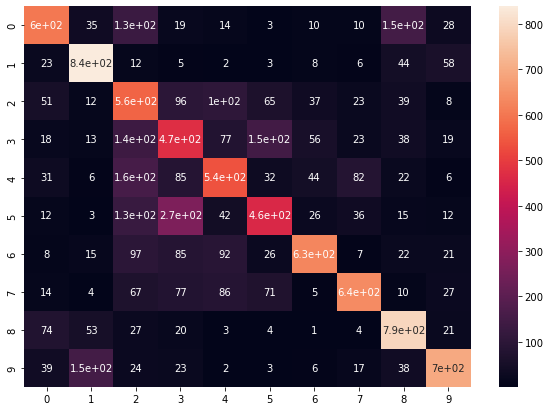

              precision    recall  f1-score   support

           0       0.69      0.60      0.64      1000
           1       0.74      0.84      0.79      1000
           2       0.42      0.56      0.48      1000
           3       0.41      0.47      0.44      1000
           4       0.56      0.54      0.55      1000
           5       0.56      0.46      0.51      1000
           6       0.76      0.63      0.69      1000
           7       0.75      0.64      0.69      1000
           8       0.68      0.79      0.73      1000
           9       0.78      0.70      0.74      1000

    accuracy                           0.62     10000
   macro avg       0.64      0.62      0.63     10000
weighted avg       0.64      0.62      0.63     10000

Accuracy: 0.6228


In [17]:
# evaluate the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [18]:
# record the loss and accuracy
evalHistory = []
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])

[1.0615321397781372, 0.6227999925613403]


In [19]:
# get a list of low margin inference
def getLowMargin(proba, bound=0.01):
    ls = []
    for i in range(len(proba)):
        margin = proba[i][np.argsort(proba[i])][-1] - proba[i][np.argsort(proba[i])][-2]
        if margin < bound:
            ls.append([i,margin])
    return ls

In [20]:
# get a list of high probability inference
def getHighProb(proba, bound):
    ls = []
    for i in range(len(proba)):
        for p in range(len(proba[i])):
            if proba[i,p] > bound:
                ls.append([i,p])
    return ls

In [21]:
from keras.utils import np_utils
# concatenate initial training data with low margin of 1st and 2nd choice inference and high probability
# removing them from remaining data
def concatData(proba, remainX, remainY, xTrain, yTrain, Lbound=0.01, Hbound=0.99):
    lm = getLowMargin(proba, Lbound)
    print("number of data with first and second choice probability lower than {0}: {1}".format(Lbound,len(lm)))
    hp = getHighProb(proba, Hbound)
    print("number of data with probability higher than {0}: {1}".format(Hbound,len(hp)))
    
    nlm = np.array(np.array(lm)[:,0], dtype="int32")
    lxAdd = remainX[nlm]
    lyAdd = remainY[nlm]
    print("x shape to be added from low margin: {0}\ny shape to be added: {1}".format(lxAdd.shape, lyAdd.shape))
    
    nhp = np.array(hp)
    hxAdd = remainX[nhp[:,0]]
    hyAdd = np.array([nhp[:,1]]).T
    hyAdd = keras.utils.np_utils.to_categorical(hyAdd, num_classes)
    yActual = remainY[nhp[:,0]]
    print("x shape to be added from high probability: {0}\ny shape to be added: {1}".format(hxAdd.shape, hyAdd.shape))
    
    ixAdd = np.vstack((lxAdd, hxAdd))
    iyAdd = np.vstack((lyAdd, hyAdd))
    nlmhp = np.hstack((nhp[:,0],nlm))
    
    NewXTrain = np.vstack((xTrain, ixAdd))
    NewYTrain = np.vstack((yTrain, iyAdd))
    print("new training data:\n\tx: {0}\n\ty: {1}".format(NewXTrain.shape, NewYTrain.shape))
    
    remainX2 = np.delete(remainX, nlmhp, axis=0)
    remainY2 = np.delete(remainY, nlmhp, axis=0)
    print("remaining data:\n\tx: {0}\n\ty: {1}".format(remainX2.shape, remainY2.shape))
        
    yEval = [[yActual[i],hyAdd[i]] for i in range(len(hyAdd))]
    
    return remainX2, remainY2, NewXTrain, NewYTrain, yEval

In [22]:
def getError(yEval):
    errLabel = [0]*10
    for i in range(len(yEval)):
        if False in (yEval[i][0] == yEval[i][1]):
            errLabel[np.argmax(yEval[i][0]-yEval[i][1])] += 1
    return errLabel

In [23]:
# proba = model.predict_proba(remainXTrain, verbose=0)
proba=model.predict(remainXTrain,verbose=0)

In [24]:
# get new training data from high probability
remainXTrain, remainYTrain, x_train2, y_train2, yEval= concatData(proba, 
                                                                  remainXTrain, 
                                                                  remainYTrain, 
                                                                  x_train1, 
                                                                  y_train1, 
                                                                  0.01,
                                                                  0.9999)
errPred = getError(yEval)

number of data with first and second choice probability lower than 0.01: 809
number of data with probability higher than 0.9999: 55
x shape to be added from low margin: (809, 32, 32, 3)
y shape to be added: (809, 10)
x shape to be added from high probability: (55, 32, 32, 3)
y shape to be added: (55, 10)
new training data:
	x: (10864, 32, 32, 3)
	y: (10864, 10)
remaining data:
	x: (39136, 32, 32, 3)
	y: (39136, 10)


In [25]:
# retrain the model
model = trainModel(model, x_train2, y_train2, x_test, y_test)


Epoch 1: val_loss improved from inf to 1.02210, saving model to ./cifar10/combTest100\Cifar10_.01-0.93-1.02.hdf5

Epoch 2: val_loss improved from 1.02210 to 0.97274, saving model to ./cifar10/combTest100\Cifar10_.02-0.83-0.97.hdf5

Epoch 3: val_loss did not improve from 0.97274
Epoch 3: early stopping


In [26]:
# load the newest checkpoint model to get the best accuracy one
model = getNewestModel()

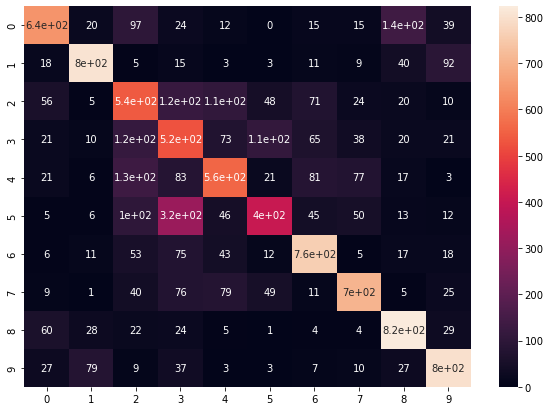

              precision    recall  f1-score   support

           0       0.74      0.64      0.69      1000
           1       0.83      0.80      0.82      1000
           2       0.48      0.54      0.51      1000
           3       0.41      0.53      0.46      1000
           4       0.60      0.56      0.58      1000
           5       0.62      0.40      0.49      1000
           6       0.71      0.76      0.73      1000
           7       0.75      0.70      0.73      1000
           8       0.74      0.82      0.78      1000
           9       0.76      0.80      0.78      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000

Accuracy: 0.6556


In [27]:
# evaluate with the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [28]:
# record the loss and accuracy
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])

[0.9727358222007751, 0.6556000113487244]


In [29]:
for i in range(100):
    #proba = model.predict_proba(remainXTrain, verbose=0)
    proba=model.predict(remainXTrain,verbose=0)
    # get new training data from high probability
    remainXTrain, remainYTrain, x_train2, y_train2, yEval= concatData(proba, 
                                                                      remainXTrain, 
                                                                      remainYTrain, 
                                                                      x_train2, 
                                                                      y_train2, 
                                                                      0.01,
                                                                      0.9999)
    errPred2 = getError(yEval)
    errPred = [errPred2[i]+errPred[i] for i in range(len(errPred))]
    model = trainModel(model, x_train2, y_train2, x_test, y_test)
    model = getNewestModel()
    evalHistory.append(evaluate(model, x_test, y_test, display=False))
    print("\nAfter Iter: {0}\n\tLoss and Acc: {1}\n".format(i,evalHistory[-1]))

number of data with first and second choice probability lower than 0.01: 583
number of data with probability higher than 0.9999: 153
x shape to be added from low margin: (583, 32, 32, 3)
y shape to be added: (583, 10)
x shape to be added from high probability: (153, 32, 32, 3)
y shape to be added: (153, 10)
new training data:
	x: (11600, 32, 32, 3)
	y: (11600, 10)
remaining data:
	x: (38400, 32, 32, 3)
	y: (38400, 10)

Epoch 1: val_loss improved from inf to 1.01393, saving model to ./cifar10/combTest100\Cifar10_.01-0.78-1.01.hdf5

Epoch 2: val_loss improved from 1.01393 to 0.95170, saving model to ./cifar10/combTest100\Cifar10_.02-0.69-0.95.hdf5

Epoch 3: val_loss did not improve from 0.95170
Epoch 3: early stopping

After Iter: 0
	Loss and Acc: [0.951697051525116, 0.6789000034332275]

number of data with first and second choice probability lower than 0.01: 460
number of data with probability higher than 0.9999: 385
x shape to be added from low margin: (460, 32, 32, 3)
y shape to be ad


Epoch 1: val_loss improved from inf to 0.97132, saving model to ./cifar10/combTest100\Cifar10_.01-0.30-0.97.hdf5

Epoch 2: val_loss did not improve from 0.97132
Epoch 2: early stopping

After Iter: 11
	Loss and Acc: [0.9713157415390015, 0.7163000106811523]

number of data with first and second choice probability lower than 0.01: 224
number of data with probability higher than 0.9999: 245
x shape to be added from low margin: (224, 32, 32, 3)
y shape to be added: (224, 10)
x shape to be added from high probability: (245, 32, 32, 3)
y shape to be added: (245, 10)
new training data:
	x: (22698, 32, 32, 3)
	y: (22698, 10)
remaining data:
	x: (27302, 32, 32, 3)
	y: (27302, 10)

Epoch 1: val_loss improved from inf to 1.00697, saving model to ./cifar10/combTest100\Cifar10_.01-0.29-1.01.hdf5

Epoch 2: val_loss did not improve from 1.00697
Epoch 2: early stopping

After Iter: 12
	Loss and Acc: [1.0069714784622192, 0.715399980545044]

number of data with first and second choice probability lower

number of data with first and second choice probability lower than 0.01: 133
number of data with probability higher than 0.9999: 427
x shape to be added from low margin: (133, 32, 32, 3)
y shape to be added: (133, 10)
x shape to be added from high probability: (427, 32, 32, 3)
y shape to be added: (427, 10)
new training data:
	x: (30601, 32, 32, 3)
	y: (30601, 10)
remaining data:
	x: (19399, 32, 32, 3)
	y: (19399, 10)

Epoch 1: val_loss improved from inf to 1.10120, saving model to ./cifar10/combTest100\Cifar10_.01-0.23-1.10.hdf5

Epoch 2: val_loss did not improve from 1.10120
Epoch 2: early stopping

After Iter: 23
	Loss and Acc: [1.1012035608291626, 0.7365999817848206]

number of data with first and second choice probability lower than 0.01: 98
number of data with probability higher than 0.9999: 383
x shape to be added from low margin: (98, 32, 32, 3)
y shape to be added: (98, 10)
x shape to be added from high probability: (383, 32, 32, 3)
y shape to be added: (383, 10)
new training 

number of data with probability higher than 0.9999: 560
x shape to be added from low margin: (85, 32, 32, 3)
y shape to be added: (85, 10)
x shape to be added from high probability: (560, 32, 32, 3)
y shape to be added: (560, 10)
new training data:
	x: (36622, 32, 32, 3)
	y: (36622, 10)
remaining data:
	x: (13378, 32, 32, 3)
	y: (13378, 10)

Epoch 1: val_loss improved from inf to 1.20841, saving model to ./cifar10/combTest100\Cifar10_.01-0.24-1.21.hdf5

Epoch 2: val_loss did not improve from 1.20841
Epoch 2: early stopping

After Iter: 34
	Loss and Acc: [1.2084105014801025, 0.7450000047683716]

number of data with first and second choice probability lower than 0.01: 80
number of data with probability higher than 0.9999: 306
x shape to be added from low margin: (80, 32, 32, 3)
y shape to be added: (80, 10)
x shape to be added from high probability: (306, 32, 32, 3)
y shape to be added: (306, 10)
new training data:
	x: (37008, 32, 32, 3)
	y: (37008, 10)
remaining data:
	x: (12992, 32, 32


Epoch 1: val_loss improved from inf to 1.32435, saving model to ./cifar10/combTest100\Cifar10_.01-0.26-1.32.hdf5

Epoch 2: val_loss did not improve from 1.32435
Epoch 2: early stopping

After Iter: 45
	Loss and Acc: [1.3243459463119507, 0.7475000023841858]

number of data with first and second choice probability lower than 0.01: 62
number of data with probability higher than 0.9999: 220
x shape to be added from low margin: (62, 32, 32, 3)
y shape to be added: (62, 10)
x shape to be added from high probability: (220, 32, 32, 3)
y shape to be added: (220, 10)
new training data:
	x: (40546, 32, 32, 3)
	y: (40546, 10)
remaining data:
	x: (9454, 32, 32, 3)
	y: (9454, 10)

Epoch 1: val_loss improved from inf to 1.28203, saving model to ./cifar10/combTest100\Cifar10_.01-0.29-1.28.hdf5

Epoch 2: val_loss did not improve from 1.28203
Epoch 2: early stopping

After Iter: 46
	Loss and Acc: [1.2820252180099487, 0.746399998664856]

number of data with first and second choice probability lower than

new training data:
	x: (42653, 32, 32, 3)
	y: (42653, 10)
remaining data:
	x: (7347, 32, 32, 3)
	y: (7347, 10)

Epoch 1: val_loss improved from inf to 1.30811, saving model to ./cifar10/combTest100\Cifar10_.01-0.29-1.31.hdf5

Epoch 2: val_loss improved from 1.30811 to 1.28310, saving model to ./cifar10/combTest100\Cifar10_.02-0.28-1.28.hdf5

Epoch 3: val_loss improved from 1.28310 to 1.12417, saving model to ./cifar10/combTest100\Cifar10_.03-0.27-1.12.hdf5

Epoch 4: val_loss did not improve from 1.12417
Epoch 4: early stopping

After Iter: 56
	Loss and Acc: [1.1241657733917236, 0.7595000267028809]

number of data with first and second choice probability lower than 0.01: 78
number of data with probability higher than 0.9999: 67
x shape to be added from low margin: (78, 32, 32, 3)
y shape to be added: (78, 10)
x shape to be added from high probability: (67, 32, 32, 3)
y shape to be added: (67, 10)
new training data:
	x: (42798, 32, 32, 3)
	y: (42798, 10)
remaining data:
	x: (7202, 32, 32


Epoch 2: val_loss did not improve from 1.21551
Epoch 2: early stopping

After Iter: 67
	Loss and Acc: [1.2155063152313232, 0.7552000284194946]

number of data with first and second choice probability lower than 0.01: 54
number of data with probability higher than 0.9999: 73
x shape to be added from low margin: (54, 32, 32, 3)
y shape to be added: (54, 10)
x shape to be added from high probability: (73, 32, 32, 3)
y shape to be added: (73, 10)
new training data:
	x: (44548, 32, 32, 3)
	y: (44548, 10)
remaining data:
	x: (5452, 32, 32, 3)
	y: (5452, 10)

Epoch 1: val_loss improved from inf to 1.30662, saving model to ./cifar10/combTest100\Cifar10_.01-0.37-1.31.hdf5

Epoch 2: val_loss did not improve from 1.30662
Epoch 2: early stopping

After Iter: 68
	Loss and Acc: [1.3066147565841675, 0.7565000057220459]

number of data with first and second choice probability lower than 0.01: 48
number of data with probability higher than 0.9999: 62
x shape to be added from low margin: (48, 32, 32, 3

remaining data:
	x: (4299, 32, 32, 3)
	y: (4299, 10)

Epoch 1: val_loss improved from inf to 1.32357, saving model to ./cifar10/combTest100\Cifar10_.01-0.35-1.32.hdf5

Epoch 2: val_loss improved from 1.32357 to 1.25090, saving model to ./cifar10/combTest100\Cifar10_.02-0.33-1.25.hdf5

Epoch 3: val_loss did not improve from 1.25090
Epoch 3: early stopping

After Iter: 79
	Loss and Acc: [1.2509033679962158, 0.758400022983551]

number of data with first and second choice probability lower than 0.01: 36
number of data with probability higher than 0.9999: 67
x shape to be added from low margin: (36, 32, 32, 3)
y shape to be added: (36, 10)
x shape to be added from high probability: (67, 32, 32, 3)
y shape to be added: (67, 10)
new training data:
	x: (45804, 32, 32, 3)
	y: (45804, 10)
remaining data:
	x: (4196, 32, 32, 3)
	y: (4196, 10)

Epoch 1: val_loss improved from inf to 1.28115, saving model to ./cifar10/combTest100\Cifar10_.01-0.35-1.28.hdf5

Epoch 2: val_loss did not improve from 1.2

number of data with first and second choice probability lower than 0.01: 20
number of data with probability higher than 0.9999: 53
x shape to be added from low margin: (20, 32, 32, 3)
y shape to be added: (20, 10)
x shape to be added from high probability: (53, 32, 32, 3)
y shape to be added: (53, 10)
new training data:
	x: (46635, 32, 32, 3)
	y: (46635, 10)
remaining data:
	x: (3365, 32, 32, 3)
	y: (3365, 10)

Epoch 1: val_loss improved from inf to 1.34392, saving model to ./cifar10/combTest100\Cifar10_.01-0.34-1.34.hdf5

Epoch 2: val_loss did not improve from 1.34392
Epoch 2: early stopping

After Iter: 90
	Loss and Acc: [1.3439245223999023, 0.7551000118255615]

number of data with first and second choice probability lower than 0.01: 27
number of data with probability higher than 0.9999: 44
x shape to be added from low margin: (27, 32, 32, 3)
y shape to be added: (27, 10)
x shape to be added from high probability: (44, 32, 32, 3)
y shape to be added: (44, 10)
new training data:
	x: (

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed